In [1]:
import numpy  as np
import matplotlib.pyplot as plt
import cv2
import statsmodels.api as sm

/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/Torgeir/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
num_train_images = 100
num_test_images = 10

In [3]:
np.random.seed(0)

In [4]:
# parameters
n = (100,100) # size of grid
R = 40    # degree of continuity
 
## code
xx,yy = np.meshgrid(np.arange(0,n[0],1)-n[0]//2,np.arange(0,n[1],1)-n[1]//2)
C = np.exp(-3*np.sqrt(xx*xx+yy*yy)/R)
fftC = np.fft.fft2(C)

dataset = np.empty((0,100,100))
for i in range(num_train_images):
    fftN = np.fft.fft2(np.random.normal(size=n))
    sample = np.real(np.fft.ifft2(np.sqrt(np.abs(fftC))*fftN))
    dataset = np.concatenate((dataset, np.expand_dims(sample, axis=0)), axis=0)
 
dataset = (dataset-np.min(dataset))/(np.max(dataset)-np.min(dataset))
 
# plotting
#plt.imshow(sample)
#plt.colorbar()


In [5]:
test_dataset = np.empty((0,100,100))
for i in range(num_test_images):
    fftN = np.fft.fft2(np.random.normal(size=n))
    sample = np.real(np.fft.ifft2(np.sqrt(np.abs(fftC))*fftN))
    test_dataset = np.concatenate((test_dataset, np.expand_dims(sample, axis=0)), axis=0)
test_dataset = (test_dataset-np.min(test_dataset))/(np.max(test_dataset)-np.min(test_dataset))

In [5]:
#plt.imshow(dataset[1])
#plt.colorbar()


In [7]:
dataset2 = np.pad(dataset,((0,0),(5,5),(5,5)), mode='constant', constant_values=0.5)
test_dataset2 = np.pad(test_dataset,((0,0),(5,5),(5,5)), mode='constant', constant_values=0.5)

In [8]:
def create_nbh(ims, nbh_size):
    m, n = nbh_size    
    train_dat = []
    for im in ims:
        for i in range(m, im.shape[0]-m):
            for j in range(n, im.shape[1]-n):
                    
                neighborhood = im[i+1-m:i+1,j-n:(j+n+1)]
                flat_n = neighborhood.flatten()
                    
                dlt = n
                    
                nbh_ij = flat_n[:-(dlt)]
                train_dat.append(nbh_ij)
    train_dat = np.array(train_dat)
    #print(train_dat.shape)
    return np.array(np.concatenate((np.ones((train_dat.shape[0],1)),train_dat),axis=1))



In [9]:
neighborhood_data = create_nbh(ims=dataset2,nbh_size=(5,5))
np.array(neighborhood_data).shape

(1000000, 51)

In [10]:
def lin_reg(train_dat):
    model = sm.OLS(train_dat[:,-1], train_dat[:,:-1])
    results = model.fit()
    betas = results.params
    
    y_pred = train_dat[:,1:-1]@betas[1:] + betas[0] 
    y_true = train_dat[:,-1]
    sigma2_hat = np.mean((y_true - y_pred)**2)

    return betas, sigma2_hat



In [11]:
parameters_estimate = lin_reg(neighborhood_data)

In [12]:
parameters_estimate[0][0]

0.003045885526050507

In [13]:
parameters_estimate[1]

0.001138318551013785

In [16]:
#parameters_estimate[0]

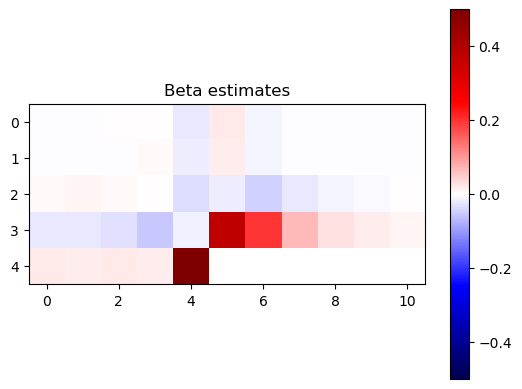

In [14]:
plt.imshow(np.concatenate((parameters_estimate[0][1:],np.array([np.inf,np.nan,np.nan,np.nan,np.nan,np.nan]))).reshape((5,11)),cmap='seismic',vmin=-0.5, vmax=0.5)#,vmin=0)
plt.colorbar()
plt.title("Beta estimates")
plt.savefig('../figures/GRF_beta_est.jpg')

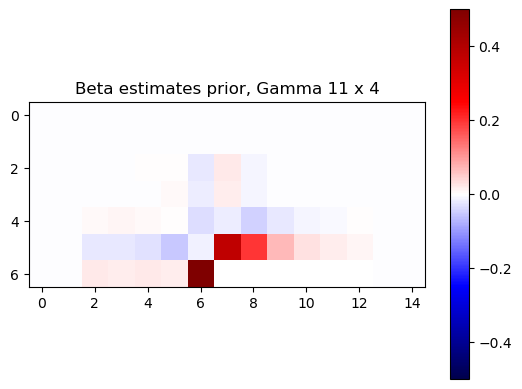

In [15]:
plt.imshow(np.pad(np.concatenate((parameters_estimate[0][1:],np.array([np.inf,np.nan,np.nan,np.nan,np.nan,np.nan]))).reshape((5,11)),((2,0),(2,2))),cmap='seismic',vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title("Beta estimates prior, Gamma 11 x 4")
plt.savefig('../Gen_with_blur/lin_gen_hyperpar_exp/beta_figures/prior_GRF_beta_est.jpg')

In [18]:
#np.sqrt(0.0010763107149353594)

In [32]:
def seq_sim(new_im, params, nbh_size):
    betas, sigma2 = params
    #new_im = np.zeros(im_shape)
    #new_im = dataset[4]
    new_im_sample = new_im.copy()
    #new_im_sample = np.zeros(new_im.shape)
    #new_im_sample = np.full(new_im.shape,0.5)
    pred_im = np.full(new_im.shape,0.5) #new_im.copy()

    m, n = nbh_size
    for i in range(m, new_im.shape[0]-m):
        for j in range(n, new_im.shape[1]-n):
            #neighborhood = new_im[i-m:i,j-n:j+n+1]
            neighborhood = new_im_sample[(i+1-m):i+1,(j-n):(j+n+1)]
            flat_n = neighborhood.flatten()

            dlt = n

            #nbh_ij = flat_n[:-(dlt+1)]
            nbh_ij = flat_n[:-(dlt)]
            #mu_pred = np.dot(betas[:],nbh_ij)
            mu_pred = nbh_ij[:-1]@betas[1:]+betas[0]

            sample = np.random.normal(mu_pred, np.sqrt(sigma2))
            pred = mu_pred

            #new_im_sample[i,j] = sample
            pred_im[i,j] = pred

    return pred_im[m:-m, n:-n]#new_im_sample[m:-m, n:-n]#pred_im[m:-m, n:-n]#pred_imnew_im_sample[m:-m, n:-n]

In [18]:
seq_sim_sample = seq_sim(test_dataset2[2],parameters_estimate, (5,5))

In [19]:
seq_sim_sample2 = seq_sim(test_dataset[8],parameters_estimate, (5,5))

In [20]:
seq_sim_sample3 = seq_sim(np.random.random((100,100)),parameters_estimate, (5,5))

In [66]:
seq_sim_pred = seq_sim(test_dataset[7],parameters_estimate, (5,5))

In [21]:
seq_sim_sample.shape

(100, 100)

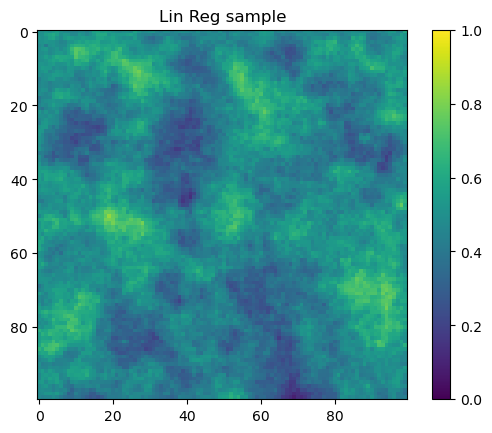

In [22]:
plt.imshow(seq_sim_sample, vmin=0,vmax=1)

plt.colorbar()
plt.title('Lin Reg sample')
#plt.savefig('../figures/GRF_sample_im1.jpg')
plt.show()

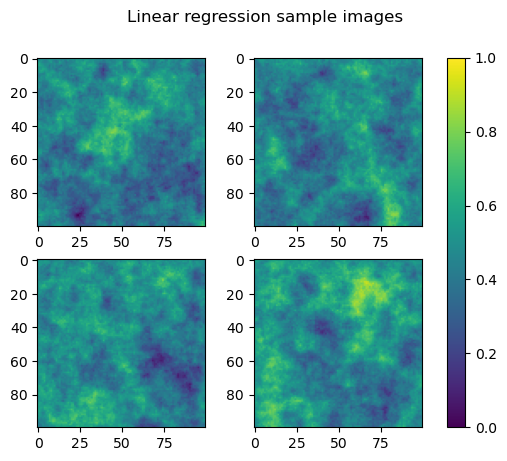

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2)
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    seq_sim_sample = seq_sim(test_dataset2[2],parameters_estimate, (5,5))
    im = ax.imshow(seq_sim_sample, vmin=0, vmax=1)

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Linear regression sample images')
#fig.tight_layout()
plt.savefig('../figures/GRF_sample_im1.jpg')


In [26]:
#plt.imshow(test_dataset[2],vmin=0,vmax=1)
#plt.colorbar()

In [27]:
#plt.imshow(np.abs(test_dataset[2]-seq_sim_sample),vmin=0,vmax=1)
#plt.colorbar()

In [33]:
#plt.imshow(seq_sim_sample, vmin=0,vmax=1)
#x = [5, 95]
#y = [50, 50]
#xx = [5, 5]
#yy = [50, 99]
#xxx = [95, 95]
#yyy = [50, 99]
#plt.plot(x, y, color="red", linewidth=1)
#plt.plot(xx, yy, color="red", linewidth=1)
#plt.plot(xxx, yyy, color="red", linewidth=1)
##plt.colorbar()
#plt.title('Lin Reg sample')
#plt.savefig('../figures/GRF_sample_im1.jpg')
#plt.show()

In [34]:
#plt.imshow(seq_sim_sample2, vmin=0,vmax=1)
#x = [5, 95]
#y = [5, 5]
###xx = [5, 5]
#yy = [5, 99]
#xxx = [95, 95]
#yyy = [5, 99]
##plt.plot(x, y, color="red", linewidth=1)
#plt.plot(xx, yy, color="red", linewidth=1)
#plt.plot(xxx, yyy, color="red", linewidth=1)
#plt.colorbar()
#plt.title('Lin Reg sample 2')
#plt.savefig('../figures/GRF_sample_im2.jpg')
#plt.show()

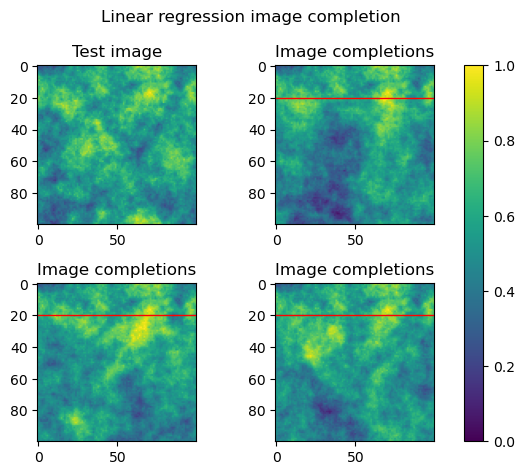

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2)
x = [0, 99]
y = [20, 20]
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    if i==0:
        im = ax.imshow(test_dataset[2], vmin=0, vmax=1)
        ax.set_title("Test image")
    else:
        seq_sim_sample3 = seq_sim(test_dataset2[2],parameters_estimate, (5,5))
        im = ax.imshow(seq_sim_sample3, vmin=0, vmax=1)
        ax.plot(x, y, color="red", linewidth=1)
        ax.set_title("Image completions")

#image = fig.colorbar(im, ax=axes.ravel().tolist())

fig.suptitle('Linear regression image completion')
fig.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig('../figures/GRF_sample_im2.jpg')


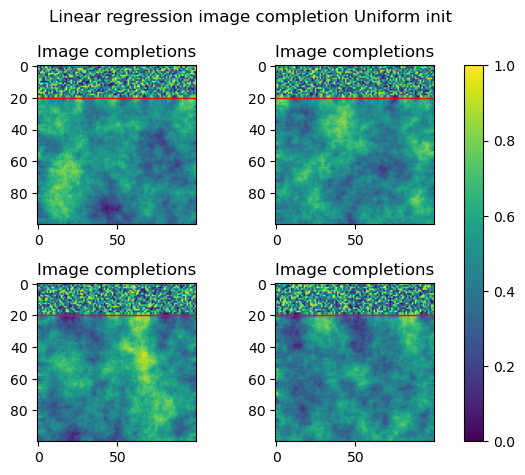

In [29]:
np.random.random((100,100))
fig, axes = plt.subplots(nrows=2, ncols=2)
x = [0, 99]
y = [20, 20]
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    #if i==0:
        #im = ax.imshow(test_dataset[2], vmin=0, vmax=1)
        #ax.set_title("Test image")
    #else:
    seq_sim_sample3 = seq_sim(np.random.random((110,110)),parameters_estimate, (5,5))
    im = ax.imshow(seq_sim_sample3, vmin=0, vmax=1)
    ax.plot(x, y, color="red", linewidth=1)
    ax.set_title("Image completions")

#image = fig.colorbar(im, ax=axes.ravel().tolist())

fig.suptitle('Linear regression image completion Uniform init')
fig.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig('../figures/GRF_sample_im3.jpg')

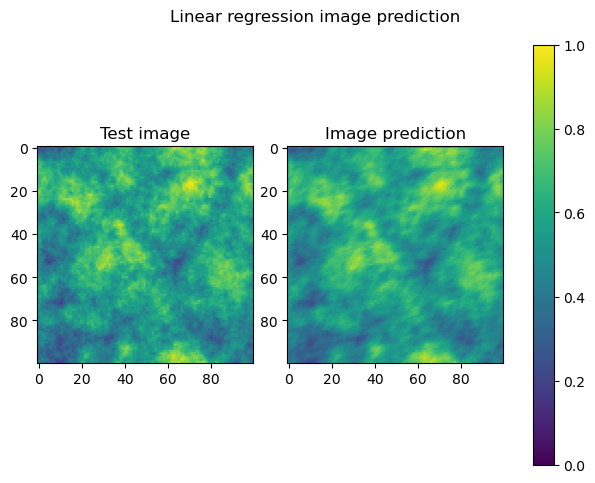

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2)
x = [0, 99]
y = [20, 20]
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    if i==0:
        im = ax.imshow(test_dataset[2], vmin=0, vmax=1)
        ax.set_title("Test image")
    else:
        seq_sim_sample3 = seq_sim(test_dataset2[2],parameters_estimate, (5,5))
        im = ax.imshow(seq_sim_sample3, vmin=0, vmax=1)
        #ax.plot(x, y, color="red", linewidth=1)
        ax.set_title("Image prediction")

#image = fig.colorbar(im, ax=axes.ravel().tolist())

fig.suptitle('Linear regression image prediction')
fig.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist())
plt.savefig('../figures/GRF_pred_im1.jpg')

In [50]:
#plt.imshow(test_dataset[7]-seq_sim_pred, vmin=0,vmax=1)

In [34]:
from scipy.stats import norm

In [35]:
seq_sim_pred = seq_sim(test_dataset2[7],parameters_estimate, (5,5))

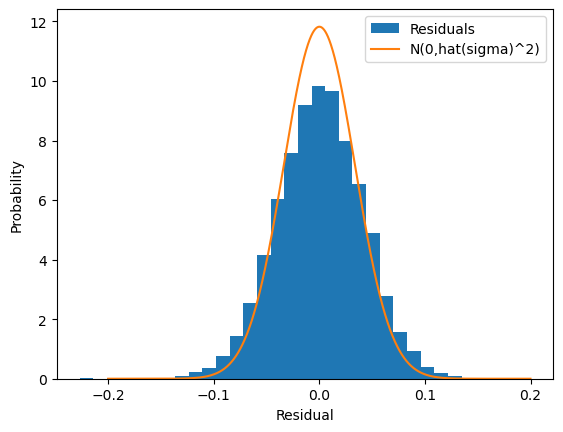

In [36]:
x = np.arange(-0.2, 0.2, 0.0001)
plt.hist((test_dataset2[7][5:105,5:105]-seq_sim_pred).flatten(), bins=30, density=True,label="Residuals")
plt.plot(x, norm.pdf(x, 0, np.sqrt(parameters_estimate[1])), label= 'N(0,hat(sigma)^2)')
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [37]:
parameters_estimate[1]


0.001138318551013785

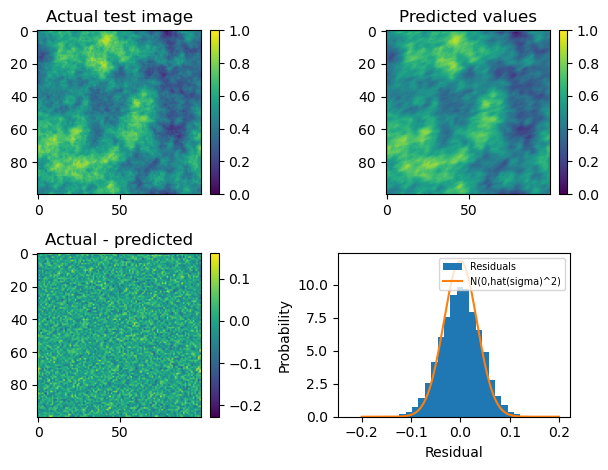

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2)#,sharex=True, sharey=True)

im = axes.flat[0].imshow(test_dataset[7], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

im = axes.flat[1].imshow(seq_sim_pred, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Predicted values")


im = axes.flat[2].imshow(test_dataset[7]-seq_sim_pred)#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Actual - predicted")

x = np.arange(-0.2, 0.2, 0.0001)
axes[1,1].hist((test_dataset2[7][5:105,5:105]-seq_sim_pred).flatten(), bins=30, density=True,label="Residuals")
axes[1,1].plot(x, norm.pdf(x, 0, np.sqrt(parameters_estimate[1])), label= 'N(0,hat(sigma)^2)')
axes[1,1].set_xlabel('Residual')
axes[1,1].set_ylabel('Probability')
axes[1,1].legend(loc='upper right',fontsize='x-small')

fig.tight_layout()
plt.savefig('../figures/GRF_pred_and_actual.jpg')
plt.show()

In [39]:
np.var((test_dataset2[7][5:105,5:105]-seq_sim_pred).flatten())

0.0016690799810527744

In [62]:
#plot train im

#for i in range(1, 5):
#    plt.subplot(2, 2, i)
#    plt.imshow(dataset[i])
#plt.colorbar()
#plt.show()

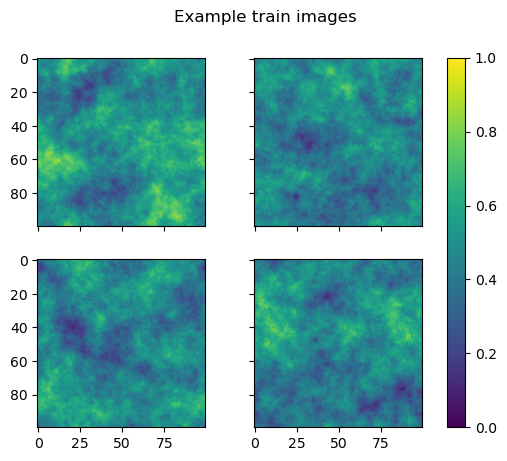

In [213]:
#plot train im

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    im = ax.imshow(dataset[i+1], vmin=0, vmax=1)

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Example train images')
plt.savefig('../figures/GRF_train_im.jpg')#, image)
plt.show()

In [71]:
image